In [23]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from imutils.paths import list_images
from sklearn import metrics
import seaborn as sns

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import copy, random, json
import pandas as pd

In [2]:
im_dir = Path('classified_cells')

labels = []
images = []

for im_path in tqdm(list(list_images(im_dir))):
    images.append(cv.imread(im_path))
    labels.append(im_path.split('/')[1])

images = np.array(images)

le = LabelEncoder()
y = le.fit_transform(labels)
print(le.classes_, le.transform(le.classes_))

100%|██████████| 5670/5670 [00:04<00:00, 1323.69it/s]

['crack' 'intact' 'intra' 'oxygen' 'solder'] [0 1 2 3 4]


In [3]:
class OneRotationTransform:
    """Rotate by one given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

solar_transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    OneRotationTransform([0,180]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) 

solar_transform_val = transforms.Compose([
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) 

In [4]:
class SolarDataset(Dataset):
    def __init__(self, images, labels, transform, transform2=None, inx_aug=None):
        self.images = images
        self.labels = torch.from_numpy(labels)
        self.transform = transform
        self.transform2 = transform2
        self.inx_aug = inx_aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(cv.cvtColor(self.images[idx], cv.COLOR_BGR2RGB))
        label = self.labels[idx]
        if self.transform2:
            if label in self.inx_aug:
                image = self.transform(image)
            else:
                image = self.transform2(image)
        else:
            image = self.transform(image)
        
        
        return image, label

In [5]:
im_train, im_test, y_train, y_test = train_test_split(images, y, test_size=0.1, shuffle=True, random_state=42)
im_train, im_val, y_train, y_val = train_test_split(im_train, y_train, test_size=0.2, shuffle=True, random_state=42)

solar_train = SolarDataset(im_train, y_train, transform=solar_transform_val)#, transform2=solar_transform_val, inx_aug=[2, 3, 4]) # determine whether to use aug
solar_val = SolarDataset(im_val, y_val, transform=solar_transform_val)
solar_test = SolarDataset(im_test, y_test, transform=solar_transform_val)

trainloader = DataLoader(solar_train, batch_size=8, shuffle=True)
valloader = DataLoader(solar_val, batch_size=8, shuffle=True)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loss_acc = {
        'train': [[],[]],
        'val': [[],[]]
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = trainloader
                dataset_size = len(solar_train)
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valloader
                dataset_size = len(solar_val)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.long()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            loss_acc[phase][0].append(epoch_loss)
            loss_acc[phase][1].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_acc

In [7]:
def result_plot(epochs, loss_accuracy, name=None):
    plt.plot(range(epochs), loss_accuracy['train'][0], label='train_loss')
    plt.plot(range(epochs), loss_accuracy['val'][0], label='val_loss')
    plt.plot(range(epochs), loss_accuracy['train'][1], label='train_acc')
    plt.plot(range(epochs), loss_accuracy['val'][1], label='val_acc')
    plt.legend()
    if name:
        plt.layout()
        plt.savefig(name, dpi=600)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 5)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [143]:
model_fit, loss_acc = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=20)

  0%|          | 0/511 [00:00<?, ?it/s]

Epoch 0/19
----------


  1%|          | 1/128 [00:00<00:17,  7.17it/s]

train Loss: 1.0799 Acc: 0.5573


  0%|          | 0/511 [00:00<?, ?it/s]

val Loss: 0.7089 Acc: 0.6259

Epoch 1/19
----------


  1%|          | 1/128 [00:00<00:17,  7.32it/s]

train Loss: 0.7673 Acc: 0.7109


  0%|          | 1/511 [00:00<01:33,  5.46it/s]

val Loss: 4.0761 Acc: 0.0695

Epoch 2/19
----------


  1%|          | 1/128 [00:00<00:17,  7.15it/s]

train Loss: 1.1487 Acc: 0.5115


  0%|          | 1/511 [00:00<01:30,  5.64it/s]

val Loss: 1.2381 Acc: 0.4701

Epoch 3/19
----------


  1%|          | 1/128 [00:00<00:17,  7.30it/s]

train Loss: 1.0633 Acc: 0.5282


  0%|          | 1/511 [00:00<01:35,  5.36it/s]

val Loss: 2.6933 Acc: 0.5015

Epoch 4/19
----------


  1%|          | 1/128 [00:00<00:17,  7.47it/s]

train Loss: 0.9389 Acc: 0.5688


  0%|          | 1/511 [00:00<01:34,  5.39it/s]

val Loss: 2.1218 Acc: 0.5847

Epoch 5/19
----------


  1%|          | 1/128 [00:00<00:16,  7.48it/s]

train Loss: 0.8867 Acc: 0.5840


  0%|          | 1/511 [00:00<01:35,  5.31it/s]

val Loss: 2.8715 Acc: 0.5759

Epoch 6/19
----------


  1%|          | 1/128 [00:00<00:17,  7.11it/s]

train Loss: 0.8720 Acc: 0.6007


  0%|          | 1/511 [00:00<01:30,  5.61it/s]

val Loss: 1.3270 Acc: 0.5896

Epoch 7/19
----------


  1%|          | 1/128 [00:00<00:17,  7.46it/s]

train Loss: 0.9124 Acc: 0.5784


  0%|          | 1/511 [00:00<01:32,  5.49it/s]

val Loss: 0.8413 Acc: 0.6170

Epoch 8/19
----------


  1%|          | 1/128 [00:00<00:16,  7.52it/s]

train Loss: 0.8110 Acc: 0.6222


  0%|          | 1/511 [00:00<01:29,  5.67it/s]

val Loss: 0.8221 Acc: 0.6072

Epoch 9/19
----------


  1%|          | 1/128 [00:00<00:17,  7.31it/s]

train Loss: 0.7520 Acc: 0.6489


  0%|          | 1/511 [00:00<01:33,  5.48it/s]

val Loss: 0.7473 Acc: 0.6308

Epoch 10/19
----------


  1%|          | 1/128 [00:00<00:17,  7.32it/s]

train Loss: 0.7567 Acc: 0.6480


  0%|          | 1/511 [00:00<01:31,  5.55it/s]

val Loss: 0.8002 Acc: 0.5955

Epoch 11/19
----------


  1%|          | 1/128 [00:00<00:17,  7.28it/s]

train Loss: 0.7487 Acc: 0.6445


  0%|          | 1/511 [00:00<01:31,  5.57it/s]

val Loss: 0.7343 Acc: 0.6249

Epoch 12/19
----------


  1%|          | 1/128 [00:00<00:16,  7.78it/s]

train Loss: 0.7362 Acc: 0.6472


  0%|          | 1/511 [00:00<01:31,  5.57it/s]

val Loss: 0.7377 Acc: 0.6170

Epoch 13/19
----------


  1%|          | 1/128 [00:00<00:17,  7.18it/s]

train Loss: 0.7227 Acc: 0.6587


  0%|          | 1/511 [00:00<01:29,  5.69it/s]

val Loss: 0.7136 Acc: 0.6435

Epoch 14/19
----------


  1%|          | 1/128 [00:00<00:17,  7.44it/s]

train Loss: 0.7049 Acc: 0.6710


  0%|          | 1/511 [00:00<01:31,  5.59it/s]

val Loss: 0.7178 Acc: 0.6014

Epoch 15/19
----------


  1%|          | 1/128 [00:00<00:16,  7.63it/s]

train Loss: 0.6991 Acc: 0.6676


  0%|          | 1/511 [00:00<01:32,  5.54it/s]

val Loss: 0.7279 Acc: 0.6308

Epoch 16/19
----------


  1%|          | 1/128 [00:00<00:16,  7.50it/s]

train Loss: 0.6982 Acc: 0.6654


  0%|          | 1/511 [00:00<01:35,  5.35it/s]

val Loss: 0.7378 Acc: 0.6141

Epoch 17/19
----------


  1%|          | 1/128 [00:00<00:16,  7.86it/s]

train Loss: 0.6938 Acc: 0.6774


  0%|          | 1/511 [00:00<01:33,  5.45it/s]

val Loss: 0.7574 Acc: 0.6033

Epoch 18/19
----------


  1%|          | 1/128 [00:00<00:17,  7.18it/s]

train Loss: 0.7026 Acc: 0.6688


  0%|          | 1/511 [00:00<01:30,  5.62it/s]

val Loss: 0.7592 Acc: 0.6043

Epoch 19/19
----------


  1%|          | 1/128 [00:00<00:17,  7.29it/s]

train Loss: 0.6928 Acc: 0.6730


100%|██████████| 128/128 [00:18<00:00,  7.01it/s]

val Loss: 0.7806 Acc: 0.6190

Best val Acc: 0.643487


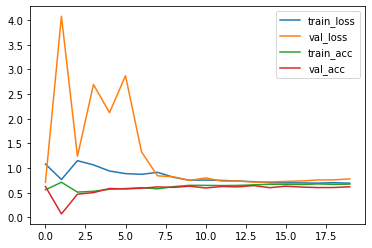

In [144]:
result_plot(20, loss_acc)
#plt.ylim(0,2)

In [131]:
torch.save(model_fit.state_dict(), './resnet50_unaug.pth')

In [56]:
# load model
model_fit = models.resnet50(pretrained=True)
num_ftrs = model_fit.fc.in_features
model_fit.fc = nn.Linear(num_ftrs, 5)
model_fit.load_state_dict(torch.load('results2/resnet50_aug_IntraSolderOxy.pth', map_location="cuda:0")) 
model_fit.to(device)
model_fit.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [57]:
pred_test = []
corrects = 0
testloader = DataLoader(solar_test, batch_size=1, shuffle=False)
with torch.no_grad():
    for input, label in tqdm(testloader):
        input = input.to(device)
        label = label.long()
        label = label.to(device)
        
        output = model_fit(input)
        _, pred = torch.max(output, 1)
        pred_test.append(int(pred))
        corrects += torch.sum(pred == label.data)

acc_test = corrects.double() / len(solar_test)
acc_test

100%|██████████| 567/567 [00:08<00:00, 64.46it/s]


tensor(0.9418, device='cuda:0', dtype=torch.float64)

In [133]:
failed_test = {
    'image': [],
    'truth': [],
    'pred': []
}

for i, truth in enumerate(y_test):
    if truth != pred_test[i]:
        failed_test['image'].append(im_test[i].tolist())
        failed_test['truth'].append(int(truth))
        failed_test['pred'].append(pred_test[i])

In [134]:
#for i, _ in enumerate(loss_acc['val'][1]):
#    loss_acc['val'][1][i] = float(loss_acc['val'][1][i])

with open('resnet50_unaug.json', 'w') as f:
    json.dump({'loss_acc': loss_acc, 'failed_test': failed_test}, f)

## Metrics report

In [15]:
def bar_plot(OT, AT, PAT, model, output, out_dir):
    ot_report = pd.read_pickle(OT)
    at_report = pd.read_pickle(AT)
    pat_report = pd.read_pickle(PAT)

    score_dic = {}
    cols = ['intact', 'crack', 'oxygen', 'intra', 'solder']
    for score in ['precision', 'recall', 'f1-score']:
        score_dic[score] = pd.DataFrame({
            'OT': ot_report.loc[score][cols],
            'AT': at_report.loc[score][cols],
            'PAT': pat_report.loc[score][cols]
            })
    b = score_dic[output].reset_index().melt('index', var_name='training set', value_name='Score')
    ax = sns.barplot(data=b, x='index', y='Score', hue='training set')
    ax.set_title((model+output).title())
    ax.set_xlabel('Category')
    plt.legend(bbox_to_anchor=(1,1), loc=2)
    plt.tight_layout()
    plt.savefig(out_dir+model+output+'.png', dpi=600)

In [58]:
test_report = pd.DataFrame(metrics.classification_report(y_test, pred_test, target_names=le.classes_, output_dict=True))
test_report.to_pickle('results3/resnet50_aug_few_report.pkl')
test_report

,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.951807,0.928839,1.000000,0.938144,1.0,0.941799,0.963758,0.942718
recall,0.908046,0.968750,0.833333,0.957895,1.0,0.941799,0.933605,0.941799
f1-score,0.929412,0.948375,0.909091,0.947917,1.0,0.941799,0.946959,0.941493
support,174.000000,256.000000,30.000000,95.000000,12.0,0.941799,567.000000,567.000000


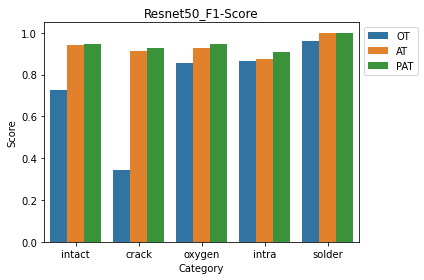

In [64]:
bar_plot(OT='results3/resnet50_report.pkl', 
         AT='results3/resnet50_aug_report.pkl',
         PAT='results3/resnet50_aug_few_report.pkl',
         model = 'resnet50_', output='f1-score', out_dir='results3/')

## confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [59]:
cm = confusion_matrix(y_test, pred_test)
cm

array([[158,  14,   0,   2,   0],
       [  7, 248,   0,   1,   0],
       [  0,   2,  25,   3,   0],
       [  1,   3,   0,  91,   0],
       [  0,   0,   0,   0,  12]])

In [60]:
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)

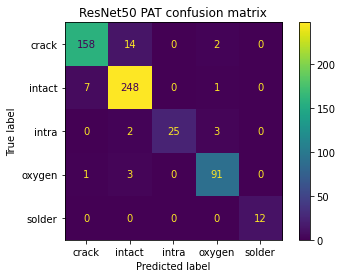

In [61]:
disp.plot()
plt.title('ResNet50 PAT confusion matrix')
plt.savefig('results3/confusion_matrix_resnet50_aug_few.png', dpi=600)